# Pairwise MLP approach

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- get links from ticlNtuplizer/graph
- convert the tracksters into some latent space and predict a link between them

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


## MLP

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, f1_score, fbeta_score
from reco.loss import FocalLoss

# from torch.utils.tensorboard import SummaryWriter

from reco.dataset import TracksterPairs


ds_name = "CloseByTwoPion"

# data_root = "data"
# raw_dir = f"/Users/ecuba/data/{ds_name}"

data_root = "/mnt/ceph/users/ecuba/processed"
raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

# writer = SummaryWriter()

In [27]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [28]:
balanced = False
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10,
    balanced=balanced,
    include_neutral=False,
    MAX_DISTANCE=10,
    ENERGY_THRESHOLD=10
)

ds.x.shape

torch.Size([95173, 43])

In [29]:
scaler = StandardScaler()
scaler.fit(ds.x)
ds.x = torch.tensor(scaler.transform(ds.x)).type(torch.float)

In [30]:
print(ds.x.shape)
print("Positive:", int((ds.y == 1).type(torch.int).sum()))
print("Neutral:", int((ds.y == 0.5).type(torch.int).sum()))
print("Negative:", int((ds.y == 0).type(torch.int).sum()))

torch.Size([95173, 43])
Positive: 30286
Neutral: 0
Negative: 64887


In [31]:
print("dataset balance:", float(sum(ds.y) / len(ds.y))) 

dataset balance: 0.31822049617767334


In [32]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 85656, Test samples: 9517


In [33]:
loss_obj = torch.nn.BCELoss() if balanced else FocalLoss(alpha=0.31, gamma=2)

def train(model, opt, loader):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == labels.type(torch.int))
    return (correct / total)

In [34]:
model = nn.Sequential(
    nn.Linear(ds.x.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Dropout(p=0.1),
    nn.Sigmoid()
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

epochs = 50

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl)
    train_acc = test(model, train_dl)
    test_acc = test(model, test_dl)
    scheduler.step()
    
    # writer.add_scalar("Loss/train", loss, epoch)
    # writer.add_scalar("Accuracy/train", train_acc, epoch)
    # writer.add_scalar("Accuracy/test", test_acc, epoch)
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

Epoch: 0, loss: 21.1225, train acc: 0.9039, test acc: 0.9029
Epoch: 5, loss: 8.6259, train acc: 0.9300, test acc: 0.9258
Epoch: 10, loss: 7.3536, train acc: 0.9371, test acc: 0.9321
Epoch: 15, loss: 6.3250, train acc: 0.9418, test acc: 0.9315
Epoch: 20, loss: 4.6785, train acc: 0.9528, test acc: 0.9346
Epoch: 25, loss: 4.0058, train acc: 0.9568, test acc: 0.9363
Epoch: 30, loss: 3.6643, train acc: 0.9602, test acc: 0.9354
Epoch: 35, loss: 3.2448, train acc: 0.9629, test acc: 0.9354
Epoch: 40, loss: 2.5265, train acc: 0.9688, test acc: 0.9367
Epoch: 45, loss: 2.2965, train acc: 0.9713, test acc: 0.9353


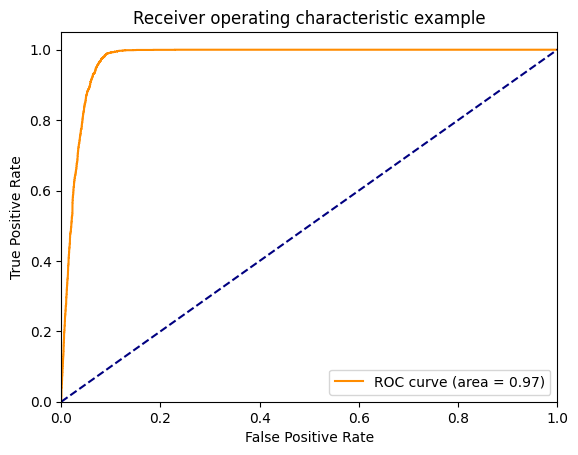

In [35]:
pred = []
lab = []
for b, l in test_dl:
    b = b.to(device)
    l = l.to(device)
    pred += model(b).tolist()
    lab += l.tolist()

fpr, tpr, _ = roc_curve(lab, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

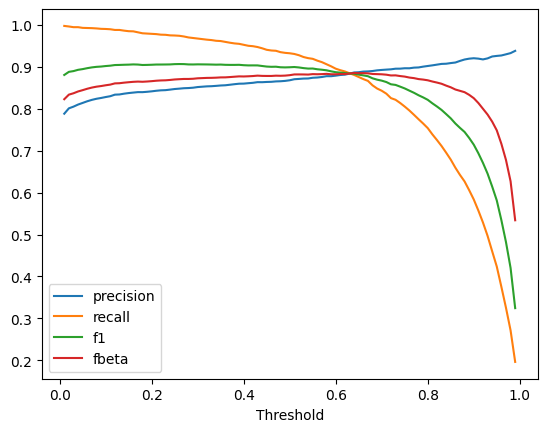

In [36]:
th_values = [i / 100. for i in range(1, 100)]
precision = []
recall = []
f1scores = []
fbeta = []

for th in th_values:
    pred = []
    lab = []
    for b, l in test_dl:
        b = b.to(device)
        l = l.to(device)
        pred += (model(b) > th).type(torch.int).tolist()
        lab += l.tolist()
    precision.append(precision_score(lab, pred))
    recall.append(recall_score(lab, pred))
    f1scores.append(f1_score(lab, pred))
    fbeta.append(fbeta_score(lab, pred, beta=0.5))

plt.figure()
plt.plot(th_values, precision, label="precision")
plt.plot(th_values, recall, label="recall")
plt.plot(th_values, f1scores, label="f1")
plt.plot(th_values, fbeta, label="fbeta")
plt.xlabel("Threshold")
plt.legend()
plt.show()

In [37]:
decision_th = th_values[np.argmax(fbeta)]

pred = []
lab = []
for b, l in test_dl:
    b = b.to(device)
    l = l.to(device)
    pred += (model(b) > decision_th).type(torch.int).tolist()
    lab += l.tolist()

tn, fp, fn, tp = confusion_matrix(lab, pred).ravel()
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
acc = accuracy_score(lab, pred)
precision = precision_score(lab, pred)
recall = recall_score(lab, pred)
f1 = f1_score(lab, pred)
fb = fbeta_score(lab, pred, beta=0.5)
print(f'TH: {decision_th} Acc: {acc:.3f} P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f} FB: {fb:.3f}')

TP: 2659, TN: 6158, FP: 340, FN: 360
TH: 0.64 Acc: 0.926 P: 0.887 R: 0.881 F1: 0.884 FB: 0.885


# Evaluation

Give the model a list of candidate edges to evaluate.
Reconstruct the event and evaluate against ground truth. 

In [38]:
import uproot
import numpy as np
from reco.evaluation import pairwise_model_evaluation

file_name = f"{raw_dir}/new_ntuples_15101852_455.root"
tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [39]:
result = pairwise_model_evaluation(
    tracksters,
    simtracksters,
    associations,
    graphs,
    model.to("cpu"),
    scaler,
    decision_th,
    max_distance=10,
    energy_threshold=10,
    max_events=10,
)

Event 0:
	clue3d_to_sim:	P: 0.99 R: 0.23 F: 0.27
	target_to_sim:	P: 0.99 R: 0.36 F: 0.41
	reco_to_target:	P: 0.82 R: 0.72 F: 0.73
	reco_to_sim:	P: 0.99 R: 0.39 F: 0.45
Event 1:
	clue3d_to_sim:	P: 1.00 R: 0.20 F: 0.24
	target_to_sim:	P: 1.00 R: 0.36 F: 0.41
	reco_to_target:	P: 0.83 R: 0.79 F: 0.80
	reco_to_sim:	P: 1.00 R: 0.42 F: 0.47
Event 2:
	clue3d_to_sim:	P: 0.96 R: 0.15 F: 0.18
	target_to_sim:	P: 0.97 R: 0.43 F: 0.48
	reco_to_target:	P: 0.76 R: 0.66 F: 0.68
	reco_to_sim:	P: 0.96 R: 0.47 F: 0.52
Event 3:
	clue3d_to_sim:	P: 1.00 R: 0.56 F: 0.61
	target_to_sim:	P: 1.00 R: 0.88 F: 0.90
	reco_to_target:	P: 1.00 R: 0.95 F: 0.96
	reco_to_sim:	P: 1.00 R: 0.82 F: 0.85
Event 4:
	clue3d_to_sim:	P: 1.00 R: 0.23 F: 0.27
	target_to_sim:	P: 1.00 R: 0.75 F: 0.79
	reco_to_target:	P: 0.81 R: 0.54 F: 0.58
	reco_to_sim:	P: 1.00 R: 0.42 F: 0.48
skipping: no candidates
Event 6:
	clue3d_to_sim:	P: 0.93 R: 0.12 F: 0.15
	target_to_sim:	P: 0.95 R: 0.40 F: 0.45
	reco_to_target:	P: 0.87 R: 0.83 F: 0.84
	reco_